## Protein Hunter Boltz

In [1]:
# @title 🧩 Setup and Core Imports
import os
from pathlib import Path
import warnings
import contextlib
import io
import copy
import yaml

import numpy as np
import pandas as pd
import torch
import random
from collections import defaultdict

# Suppress warnings for a cleaner output
warnings.filterwarnings("ignore")
warnings.filterwarnings(
    "ignore",
    message="torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly.*",
    category=UserWarning,
)

import py2Dmol
from LigandMPNN.wrapper import LigandMPNNWrapper

from boltz_ph.constants import CHAIN_TO_NUMBER
from utils.metrics import get_CA_and_sequence # Used implicitly in design.py
from utils.convert import calculate_holo_apo_rmsd, convert_cif_files_to_pdb
# -----------------------------

from boltz_ph.model_utils import (
    binder_binds_contacts,
    extract_sequence_from_structure,
    clean_memory,
    design_sequence,
    get_boltz_model,
    get_cif,
    load_canonicals,
    plot_from_pdb,
    plot_run_metrics,
    process_msa,
    run_prediction,
    sample_seq,
    save_pdb,
    shallow_copy_tensor_dict,
    smart_split,
)
print("✅ Core functionality imported.")

[14:14:04] Initializing Normalizer


✅ Core functionality imported.


In [2]:
# @title 🧬 Boltz Configuration Parameters
# --- General Setup ---
gpu_id = 0  # @param {type:"integer"}
grad_enabled = False  # @param {type:"boolean"}
name = "PDL1_SAM_binder"  # @param {type:"string"}
mode = "binder"  # @param ["unconditional", "binder"]
num_designs = 3  # @param {type:"integer"}
num_cycles = 5  # @param {type:"integer"}

save_dir = f"./results_boltz/{name}"
work_dir = os.getcwd()

# --- Sequence Length ---
min_protein_length = 100  # @param {type:"integer"}
max_protein_length = 150  # @param {type:"integer"}
cyclic = False  # @param {type:"boolean"}

# --- Target Protein(s) ---
protein_seqs = "FTVTVPKDLYVVEYGSNMTIECKFPVEKQLDLAALIVYWEMEDKNIIQFVHGEEDLKVQHSSYRQRARLLKDQLSLGNAALQITDVKLQDAGVYRCMISYGGADYKRITVKVNK"  # @param {type:"string"}
msa_mode = "mmseqs" # @param ["single", "mmseqs"]

# --- Non-Protein Components (Ligand/Nucleic Acid) ---
ligand_smiles = ""  # @param {type:"string"}
ligand_ccd = "SAM"  # @param {type:"string"}

nucleic_seq = ""  # @param {type:"string"}
nucleic_type = "dna" # @param ["dna", "rna"]

# --- Templates and Constraints ---
template_path = ""
template_cif_chain_id = "" # for mmCIF files, which chain from mmcif file to use for the template

contact_residues = "" # @param {type:"string"}  # e.g., "1,2,5,10" on target chain 
#@markdown - Specify which target chain residues must contact the binder (currently only supports protein contacts). For more than two chains, separate by |, e.g., "1,2,5,10 | 3,5,10".

contact_cutoff = 10.0
max_contact_filter_retries = 6
no_contact_filter = False

# --- Model & Diffusion Parameters ---
diffuse_steps = 200  # @param {type:"integer"}
recycling_steps = 3  # @param {type:"integer"}
boltz_model_version = "boltz2"  # @param ["boltz1", "boltz2"]
boltz_model_path = os.path.expanduser("~/.boltz/boltz2_conf.ckpt")
ccd_path = Path(os.path.expanduser("~/.boltz/mols"))
logmd = False  # @param {type:"boolean"}

# --- Design & Optimization ---
randomly_kill_helix_feature = False  # @param {type:"boolean"}
negative_helix_constant = 0.2  # @param {type:"number"}

temperature = 0.1  # @param {type:"number"}
alanine_bias = True  # @param {type:"boolean"}
alanine_bias_start = -0.5  # @param {type:"number"}
alanine_bias_end = -0.1  # @param {type:"number"}

omit_AA = "C"  # @param {type:"string"}
exclude_P = False  # @param {type:"boolean"}
percent_X = 80  # @param {type:"number"}
high_iptm_threshold = 0.8  # @param {type:"number"}
high_plddt_threshold = 0.8  # @param {type:"number"}

# --- Optional: Validation Parameters (External Dependencies) ---
#alphafold_dir = os.path.expanduser("~/alphafold3")
#af3_docker_name = "alphafold3_yc"
#af3_database_settings = os.path.expanduser("~/alphafold3/alphafold3_data_save")
#hmmer_path = os.path.expanduser("~/.conda/envs/alphafold3_venv")
#use_msa_for_af3 = False
plot = True  # @param {type:"boolean"}
viewer = True  # @param {type:"boolean"}

# Re-package parameters into an 'args' object (simple class for dot notation)
class Args:
    def __init__(self, **entries):
        self.__dict__.update(entries)

args = Args(**locals())

In [3]:
# @title ⚙️ Initialize Models and Prepare Base Data
# --- 1. Model Initialization ---
device = (
    f"cuda:{args.gpu_id}" if torch.cuda.is_available() and args.gpu_id >= 0 else "cpu"
)
print(f"Using device: {device}")

predict_args = {
    "recycling_steps": args.recycling_steps,
    "sampling_steps": args.diffuse_steps,
    "diffusion_samples": 1,
    "write_confidence_summary": True,
    "write_full_pae": False,
    "write_full_pde": False,
    "max_parallel_samples": 1,
}

ccd_lib = load_canonicals(os.path.expanduser(str(args.ccd_path)))
boltz_model = get_boltz_model(
    checkpoint=args.boltz_model_path,
    predict_args=predict_args,
    device=device,
    model_version=args.boltz_model_version,
    no_potentials=False if args.contact_residues else True,
    
    grad_enabled=args.grad_enabled,
)
designer = LigandMPNNWrapper(os.path.join(args.work_dir, "./LigandMPNN/run.py"))
protein_hunter_save_dir = os.path.join(args.save_dir, "0_protein_hunter_design")
os.makedirs(protein_hunter_save_dir, exist_ok=True)
os.makedirs(args.save_dir, exist_ok=True)


# --- 2. Data Preparation (Condensed from _build_initial_data_dict) ---
sequences = []

# --- Process sequences and assign chain IDs ---
args.binder_chain = "A"
protein_seqs_list = smart_split(args.protein_seqs) if args.protein_seqs else []

if args.msa_mode == "single":
    protein_msas_list = ["empty"] * len(protein_seqs_list)
elif args.msa_mode == "mmseqs":    
    protein_msas_list = ["mmseqs"] * len(protein_seqs_list)
else:
    raise ValueError(f"Invalid msa_mode: {args.msa_mode}")
# Assign chain IDs
protein_chain_ids = [chr(ord('B') + i) for i in range(len(protein_seqs_list))]
next_chain_idx = len(protein_chain_ids)

ligand_chain_id = None
if args.ligand_smiles or args.ligand_ccd:
    ligand_chain_id = chr(ord('B') + next_chain_idx)
    next_chain_idx += 1
    
nucleic_chain_id = None
if args.nucleic_seq:
    nucleic_chain_id = chr(ord('B') + next_chain_idx)
    next_chain_idx += 1
# --- END MODIFICATIONS ---

seq_to_indices = defaultdict(list)
for idx, seq in enumerate(protein_seqs_list):
    if seq:
        seq_to_indices[seq].append(idx)
seq_to_final_msa = {}

# Suppress MSA generation output during this phase
print("Processing MSAs (if any)...")
with contextlib.redirect_stdout(io.StringIO()) as f:
    for seq, idx_list in seq_to_indices.items():
        chosen_msa = next(
            (
                protein_msas_list[i]
                for i in idx_list
            ),
            None,
        )
        if chosen_msa == "mmseqs":
            pid = protein_chain_ids[idx_list[0]]
            msa_value = process_msa(pid, seq, Path(protein_hunter_save_dir))
            seq_to_final_msa[seq] = str(msa_value)
        elif chosen_msa == "empty":
            seq_to_final_msa[seq] = "empty"
        else:
            raise ValueError(f"Invalid msa_mode: {args.msa_mode}")


# Build sequences list
for i, (seq, msa) in enumerate(zip(protein_seqs_list, protein_msas_list)):
    if not seq:
        continue
    pid = protein_chain_ids[i]
    final_msa = seq_to_final_msa.get(seq, "empty")
    sequences.append(
        {"protein": {"id": [pid], "sequence": seq, "msa": final_msa}}
    )

sequences.append(
    {
        "protein": {
            "id": ["A"], # Binder is always 'A'
            "sequence": "X",
            "msa": "empty",
            "cyclic": args.cyclic,
        }
    }
)

if args.ligand_smiles:
    sequences.append({"ligand": {"id": [ligand_chain_id], "smiles": args.ligand_smiles}})
elif args.ligand_ccd:
    sequences.append({"ligand": {"id": [ligand_chain_id], "ccd": args.ligand_ccd}})
if args.nucleic_seq:
    sequences.append(
        {args.nucleic_type: {"id": [nucleic_chain_id], "sequence": args.nucleic_seq}}
    )

# --- Handle templates with 1-to-1 mapping ---
templates = []
if args.template_path:
    template_path_list = smart_split(args.template_path)
    template_cif_chain_id_list = (
        smart_split(args.template_cif_chain_id) if args.template_cif_chain_id else []
    )
    
    num_proteins = len(protein_chain_ids)
    
    while len(template_path_list) < num_proteins:
        template_path_list.append("")
    while len(template_cif_chain_id_list) < num_proteins:
        template_cif_chain_id_list.append("")

    for i in range(num_proteins):
        template_file_path = template_path_list[i]
        if not template_file_path:
            continue
            
        template_file = get_cif(template_file_path)
        
        t_block = (
            {"cif": template_file}
            if template_file.endswith(".cif")
            else {"pdb": template_file}
        )
        
        t_block["chain_id"] = protein_chain_ids[i]
        cif_chain = template_cif_chain_id_list[i]
        if cif_chain:
            t_block["cif_chain_id"] = cif_chain

        templates.append(t_block)

data = {"sequences": sequences}
if templates:
    data["templates"] = templates
pocket_conditioning = bool(args.contact_residues and args.contact_residues.strip())

if pocket_conditioning:
    contacts = []
    residues_chains = args.contact_residues.split("|")
    for i, residues_chain in enumerate(residues_chains):
        residues = residues_chain.split(",")
        contacts.extend([
            [protein_chain_ids[i], int(res)]
            for res in residues
            if res.strip() != ""
        ])
    constraints = [{"pocket": {"binder": "A", "contacts": contacts}}]
    data["constraints"] = constraints
    
data["sequences"] = sorted(
    data["sequences"], key=lambda entry: list(entry.values())[0]["id"][0]
)
any_ligand_or_nucleic = args.ligand_smiles or args.ligand_ccd or args.nucleic_seq
model_type = "ligand_mpnn" if any_ligand_or_nucleic else "soluble_mpnn"

print("✅ Models ready and base data configured.")
print("Mode:", args.mode)
print("Data dictionary (base):\n", data)

Using device: cuda:0
no potentials


SUBMIT:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

Processing MSAs (if any)...


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:01 remaining: 00:00]

✅ Models ready and base data configured.
Mode: binder
Data dictionary (base):
 {'sequences': [{'protein': {'id': ['A'], 'sequence': 'X', 'msa': 'empty', 'cyclic': False}}, {'protein': {'id': ['B'], 'sequence': 'FTVTVPKDLYVVEYGSNMTIECKFPVEKQLDLAALIVYWEMEDKNIIQFVHGEEDLKVQHSSYRQRARLLKDQLSLGNAALQITDVKLQDAGVYRCMISYGGADYKRITVKVNK', 'msa': 'results_boltz/PDL1_SAM_binder/0_protein_hunter_design/B_env/msa.npz'}}, {'ligand': {'id': ['C'], 'ccd': 'SAM'}}]}



=== Starting Design Run 0/2 ===
Binder initial sequence length: 101

--- Run 0, Cycle 1 ---
ipTM: 0.85, pLDDT: 0.69, iPLDDT: 0.52, Ala%: 32.7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- Run 0, Cycle 2 ---
ipTM: 0.90, pLDDT: 0.84, iPLDDT: 0.74, Ala%: 20.8


<IPython.core.display.Javascript object>


--- Run 0, Cycle 3 ---
ipTM: 0.89, pLDDT: 0.88, iPLDDT: 0.79, Ala%: 23.8


<IPython.core.display.Javascript object>


--- Run 0, Cycle 4 ---
ipTM: 0.87, pLDDT: 0.95, iPLDDT: 0.92, Ala%: 21.8


<IPython.core.display.Javascript object>


--- Run 0, Cycle 5 ---
ipTM: 0.81, pLDDT: 0.89, iPLDDT: 0.78, Ala%: 29.7


<IPython.core.display.Javascript object>

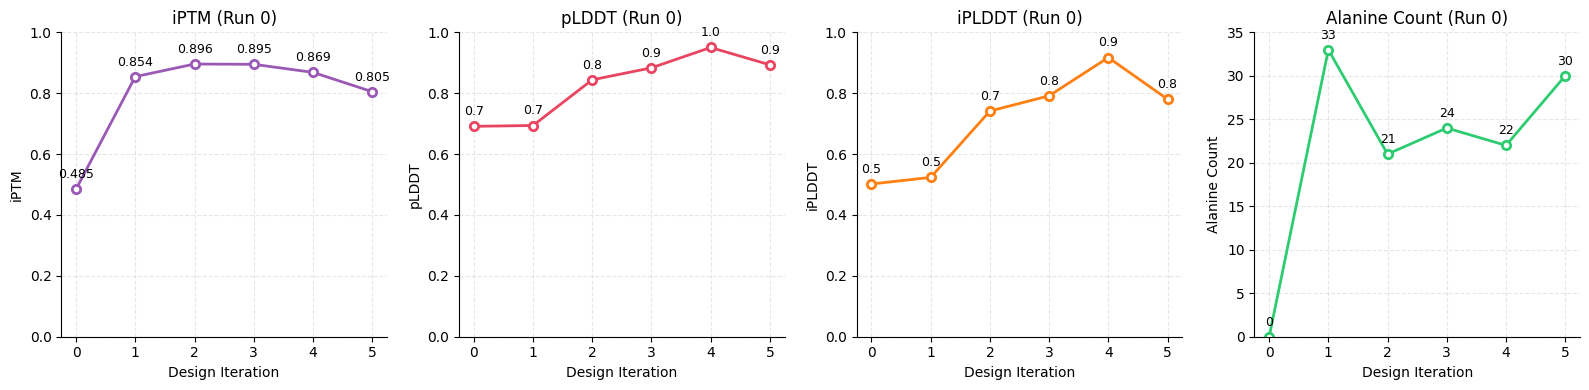


=== Starting Design Run 1/2 ===
Binder initial sequence length: 138

--- Run 1, Cycle 1 ---
ipTM: 0.84, pLDDT: 0.77, iPLDDT: 0.66, Ala%: 24.6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- Run 1, Cycle 2 ---
ipTM: 0.89, pLDDT: 0.93, iPLDDT: 0.79, Ala%: 13.0


<IPython.core.display.Javascript object>

✅ Saved run 1 cycle 2 YAML.

--- Run 1, Cycle 3 ---
ipTM: 0.87, pLDDT: 0.92, iPLDDT: 0.74, Ala%: 16.7


<IPython.core.display.Javascript object>

✅ Saved run 1 cycle 3 YAML.

--- Run 1, Cycle 4 ---
ipTM: 0.90, pLDDT: 0.91, iPLDDT: 0.71, Ala%: 20.3


<IPython.core.display.Javascript object>


--- Run 1, Cycle 5 ---
ipTM: 0.89, pLDDT: 0.93, iPLDDT: 0.81, Ala%: 23.2


<IPython.core.display.Javascript object>

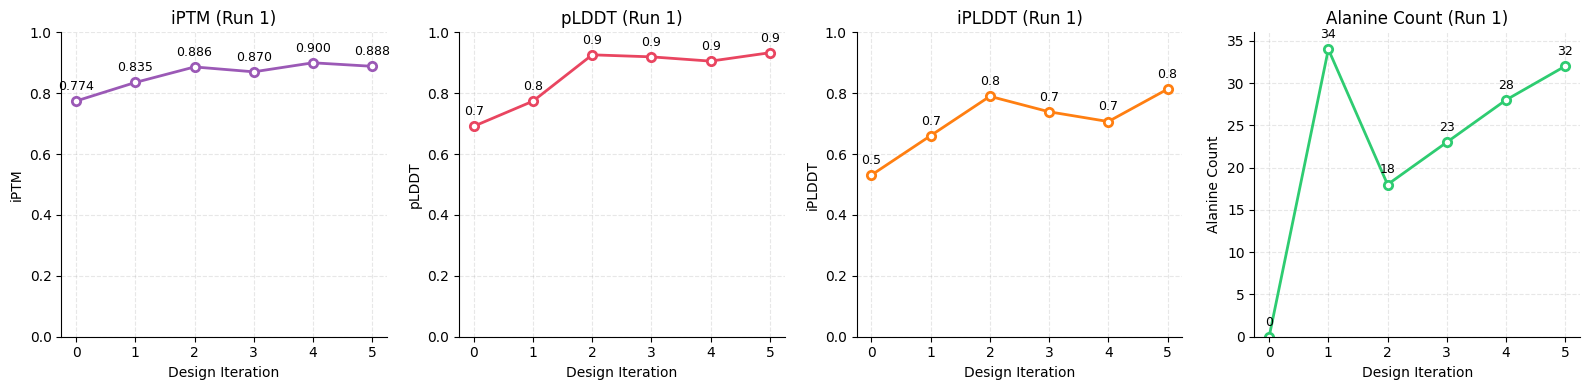


=== Starting Design Run 2/2 ===
Binder initial sequence length: 136

--- Run 2, Cycle 1 ---
ipTM: 0.91, pLDDT: 0.70, iPLDDT: 0.56, Ala%: 18.4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- Run 2, Cycle 2 ---
ipTM: 0.91, pLDDT: 0.87, iPLDDT: 0.65, Ala%: 16.9


<IPython.core.display.Javascript object>

✅ Saved run 2 cycle 2 YAML.

--- Run 2, Cycle 3 ---
ipTM: 0.87, pLDDT: 0.87, iPLDDT: 0.67, Ala%: 25.0


<IPython.core.display.Javascript object>


--- Run 2, Cycle 4 ---
ipTM: 0.77, pLDDT: 0.89, iPLDDT: 0.62, Ala%: 22.8


<IPython.core.display.Javascript object>


--- Run 2, Cycle 5 ---
ipTM: 0.89, pLDDT: 0.91, iPLDDT: 0.72, Ala%: 26.5


<IPython.core.display.Javascript object>

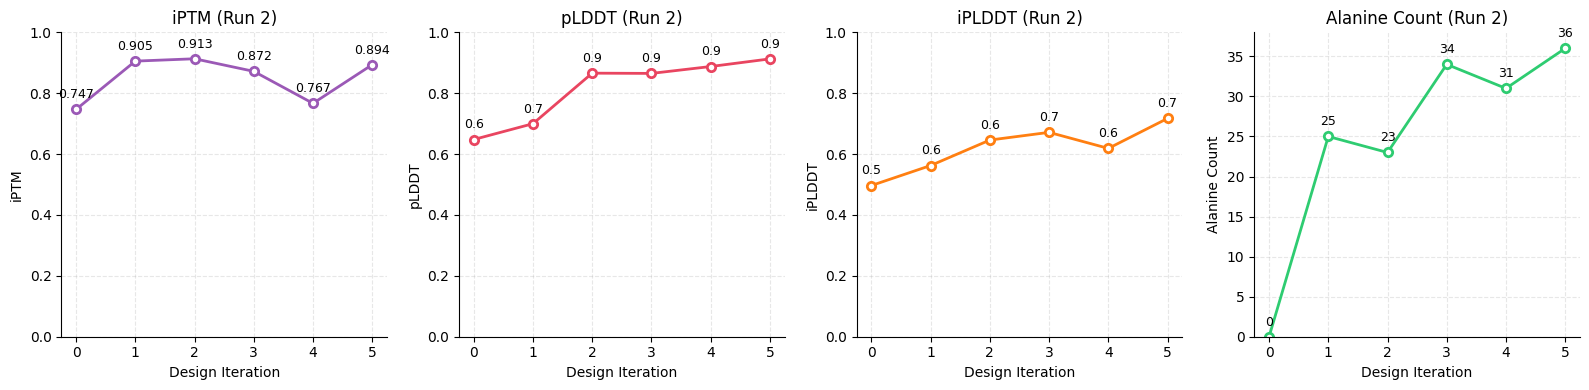


✅ All run/cycle metrics saved to ./results_boltz/PDL1_SAM_binder/summary_all_runs.csv


In [4]:
# @title 🚀 Execute Design and Optimization Loop
# Replicate the core logic from _run_design_cycle and run_pipeline's execution part
import contextlib
import io

# NOTE: Using viewer object from global scope for incremental updates
all_run_metrics = []

for design_id in range(args.num_designs):
    if viewer:
        viewer = py2Dmol.view((600,400), color="plddt")
        viewer.show()

    run_id = str(design_id)
    run_save_dir = os.path.join(args.save_dir, f"run_{run_id}")
    os.makedirs(run_save_dir, exist_ok=True)

    data_cp = copy.deepcopy(data)

    print("\n=======================================================")
    print(f"=== Starting Design Run {run_id}/{args.num_designs - 1} ===")
    print("=======================================================")

    best_iptm = float("-inf")
    best_seq = None
    best_structure = None
    best_output = None
    best_pdb_filename = None
    best_cycle_idx = -1
    best_alanine_percentage = None
    run_metrics = {"run_id": run_id}

    # --- Initial Sequence Assignment ---
    binder_length = random.randint(
        args.min_protein_length, args.max_protein_length
    )
    new_seq = sample_seq(binder_length, exclude_P=args.exclude_P, frac_X=args.percent_X/100)

    # Update binder sequence in the data dictionary copy
    for seq_entry in data_cp["sequences"]:
        if "protein" in seq_entry and args.binder_chain in seq_entry["protein"]["id"]:
            seq_entry["protein"]["sequence"] = new_seq
            break
    print(f"Binder initial sequence length: {binder_length}")

    # ========== Cycle 0 structure prediction (with contact filtering) ==========
    contact_filter_attempt = 0
    pdb_filename = ""
    structure = None
    output = None

    while True:
        # SUPPRESS UNWANTED MSA MESSAGES during prediction
        with contextlib.redirect_stdout(io.StringIO()) as f:
            output, structure = run_prediction(
                data_cp,
                args.binder_chain,
                randomly_kill_helix_feature=args.randomly_kill_helix_feature,
                negative_helix_constant=args.negative_helix_constant,
                boltz_model=boltz_model,
                ccd_lib=ccd_lib,
                ccd_path=args.ccd_path,
                logmd=args.logmd,
                device=device,
                boltz_model_version=args.boltz_model_version,
                pocket_conditioning=pocket_conditioning,
            )

        # Save Cycle 0 PDB
        pdb_filename = f"{run_save_dir}/{args.name}_run_{run_id}_predicted_cycle_0.pdb"
        plddts = output["plddt"].detach().cpu().numpy()[0]
        save_pdb(structure, output["coords"], plddts, pdb_filename)

        # Contact filtering (only if configured)
        contact_check_okay = True
        if args.contact_residues.strip() and not args.no_contact_filter:
            try:
                binds = all(
                    binder_binds_contacts(
                        pdb_filename,
                        args.binder_chain,
                        protein_chain_ids[i],
                        contact_res,
                        cutoff=args.contact_cutoff,
                    )
                    for i, contact_res in enumerate(args.contact_residues.split("|"))
                )
                if not binds:
                    print("❌ Binder does NOT contact required residues after cycle 0. Retrying...")
                    contact_check_okay = False
            except Exception as e:
                print(f"WARNING: Could not perform binder-contact check: {e}")
                contact_check_okay = True

        if contact_check_okay:
            break
        else:
            contact_filter_attempt += 1
            if contact_filter_attempt >= args.max_contact_filter_retries:
                print("⚠️ Maximum contact filter retries reached. Proceeding anyway.")
                break

            # Resample initial sequence
            new_seq = sample_seq(
                binder_length, exclude_P=args.exclude_P, frac_X=args.percent_X/100
            )
            for seq_entry in data_cp["sequences"]:
                if (
                    "protein" in seq_entry
                    and args.binder_chain in seq_entry["protein"]["id"]
                ):
                    seq_entry["protein"]["sequence"] = new_seq
                    break
            clean_memory()

    # --- Capture Cycle 0 metrics (same logic as before) ---
    binder_chain_idx = CHAIN_TO_NUMBER[args.binder_chain]
    pair_chains = output["pair_chains_iptm"]
    if len(pair_chains) > 1:
        values = [
            (
                pair_chains[binder_chain_idx][i].detach().cpu().numpy()
                + pair_chains[i][binder_chain_idx].detach().cpu().numpy()
            )
            / 2.0
            for i in range(len(pair_chains))
            if i != binder_chain_idx
        ]
        cycle_0_iptm = float(np.mean(values) if values else 0.0)
    else:
        cycle_0_iptm = 0.0
    run_metrics["cycle_0_iptm"] = cycle_0_iptm
    run_metrics["cycle_0_plddt"] = float(
        output.get("complex_plddt", torch.tensor([0.0])).detach().cpu().numpy()[0]
    )
    run_metrics["cycle_0_iplddt"] = float(
        output.get("complex_iplddt", torch.tensor([0.0])).detach().cpu().numpy()[0]
    )
    run_metrics["cycle_0_alanine"] = 0
    run_metrics["cycle_0_seq"] = new_seq

    # ===== Optimization Cycles (Cycle 1 to num_cycles) =====
    for cycle in range(args.num_cycles):
        print(f"\n--- Run {run_id}, Cycle {cycle + 1} ---")

        # Calculate temperature and bias
        cycle_norm = (cycle / (args.num_cycles - 1)) if args.num_cycles > 1 else 0.0
        alpha = args.alanine_bias_start - cycle_norm * (
            args.alanine_bias_start - args.alanine_bias_end
        )
        temperature = args.temperature
        design_kwargs = {
            "pdb_file": pdb_filename,
            "temperature": temperature,
            "chains_to_design": args.binder_chain,
            "omit_AA": f"{args.omit_AA},P" if cycle == 0 else args.omit_AA,
        }
        if args.alanine_bias:
            design_kwargs["bias_AA"] = f"A:{alpha}"

        seq_str, logits = design_sequence(designer, model_type, **design_kwargs)
        seq = seq_str.split(":")[CHAIN_TO_NUMBER[args.binder_chain]]

        alanine_count = seq.count("A")
        alanine_percentage = alanine_count / binder_length if binder_length else 0.0
        for seq_entry in data_cp["sequences"]:
            if (
                "protein" in seq_entry
                and args.binder_chain in seq_entry["protein"]["id"]
            ):
                seq_entry["protein"]["sequence"] = seq
                break

        # SUPPRESS UNWANTED MSA MESSAGES during prediction
        with contextlib.redirect_stdout(io.StringIO()) as f:
            output, structure = run_prediction(
                data_cp,
                args.binder_chain,
                seq=seq,
                randomly_kill_helix_feature=False,
                negative_helix_constant=0.0,
                boltz_model=boltz_model,
                ccd_lib=ccd_lib,
                ccd_path=args.ccd_path,
                logmd=False,
                device=device,
            )

        # Compute ipTM
        current_chain_idx = CHAIN_TO_NUMBER[args.binder_chain]
        pair_chains = output["pair_chains_iptm"]
        if len(pair_chains) > 1:
            values = [
                (
                    pair_chains[current_chain_idx][i].detach().cpu().numpy()
                    + pair_chains[i][current_chain_idx].detach().cpu().numpy()
                )
                / 2.0
                for i in range(len(pair_chains))
                if i != current_chain_idx
            ]
            current_iptm = float(np.mean(values) if values else 0.0)
        else:
            current_iptm = 0.0

        # Update best structure
        if alanine_percentage <= 0.20 and current_iptm > best_iptm:
            best_iptm = current_iptm
            best_structure = copy.deepcopy(structure)
            best_output = shallow_copy_tensor_dict(output)
            best_pdb_filename = (
                f"{run_save_dir}/{args.name}_run_{run_id}_best_structure.pdb"
            )
            best_plddts = best_output["plddt"].detach().cpu().numpy()[0]
            save_pdb(
                best_structure, best_output["coords"], best_plddts, best_pdb_filename
            )
            best_cycle_idx = cycle + 1
            best_seq = seq
            best_alanine_percentage = alanine_percentage

        # Record metrics
        curr_plddt = float(
            output.get("complex_plddt", torch.tensor([0.0])).detach().cpu().numpy()[0]
        )
        curr_iplddt = float(
            output.get("complex_iplddt", torch.tensor([0.0])).detach().cpu().numpy()[0]
        )
        run_metrics[f"cycle_{cycle + 1}_iptm"] = current_iptm
        run_metrics[f"cycle_{cycle + 1}_plddt"] = curr_plddt
        run_metrics[f"cycle_{cycle + 1}_iplddt"] = curr_iplddt
        run_metrics[f"cycle_{cycle + 1}_alanine"] = alanine_count
        run_metrics[f"cycle_{cycle + 1}_seq"] = seq

        print(
            f"ipTM: {current_iptm:.2f}, pLDDT: {curr_plddt:.2f}, iPLDDT: {curr_iplddt:.2f}, Ala%: {alanine_percentage * 100:.1f}"
        )

        pdb_filename = (
            f"{run_save_dir}/{args.name}_run_{run_id}_predicted_cycle_{cycle + 1}.pdb"
        )
        plddts = output["plddt"].detach().cpu().numpy()[0]
        save_pdb(structure, output["coords"], plddts, pdb_filename)

        if viewer:
            viewer.add_pdb(pdb_filename)
        
        # 4. Save YAML for High ipTM
        save_yaml_this_design = (alanine_percentage <= 0.20) and (
            current_iptm > high_iptm_threshold and curr_plddt > high_plddt_threshold
        )
        
        if save_yaml_this_design and args.contact_residues.strip():
            try:
                contact_binds = all(
                    binder_binds_contacts(
                        pdb_filename,
                        args.binder_chain,
                        protein_chain_ids[i],
                        contact_res,
                        cutoff=args.contact_cutoff,
                    )
                    for i, contact_res in enumerate(args.contact_residues.split("|"))
                )
                if not contact_binds:
                    save_yaml_this_design = False
                    print(
                        "⛔️ Not saving YAML: binder failed contact check for high ipTM save."
                    )
            except Exception as e:
                print(
                    f"WARNING: Exception during contact check: {e}. Saving YAML anyway."
                )

        if save_yaml_this_design:
            high_iptm_yaml_dir = os.path.join(args.save_dir, "high_iptm_yaml")
            os.makedirs(high_iptm_yaml_dir, exist_ok=True)
            yaml_filename = os.path.join(
                high_iptm_yaml_dir,
                f"{args.name}_run_{run_id}_cycle_{cycle + 1}_output.yaml",
            )
            with open(yaml_filename, "w") as f:
                yaml.dump(data_cp, f, default_flow_style=False)
            print(f"✅ Saved run {run_id} cycle {cycle + 1} YAML.")


        clean_memory()

    # --- Finalize and Plot Metrics ---
    run_metrics["best_iptm"] = float(
        best_iptm if best_iptm != float("-inf") else np.nan
    )
    run_metrics["best_cycle"] = best_cycle_idx
    run_metrics["best_seq"] = best_seq
    if best_output:
        run_metrics["best_plddt"] = float(
            best_output.get("complex_plddt", torch.tensor([np.nan]))
            .detach()
            .cpu()
            .numpy()[0]
        )
    else:
        run_metrics["best_plddt"] = np.nan
    all_run_metrics.append(run_metrics)

    if args.plot:
        plot_run_metrics(run_save_dir, args.name, run_id, args.num_cycles, run_metrics)


# ===== Save All Run Metrics to CSV =====
summary_csv = os.path.join(args.save_dir, "summary_all_runs.csv")
df = pd.DataFrame(all_run_metrics)
columns = ["run_id"]
for i in range(args.num_cycles + 1):
    columns.extend(
        [
            f"cycle_{i}_iptm",
            f"cycle_{i}_plddt",
            f"cycle_{i}_iplddt",
            f"cycle_{i}_alanine",
            f"cycle_{i}_seq",
        ]
    )
columns.extend(["best_iptm", "best_cycle", "best_plddt", "best_seq"])
for col in columns:
    if col not in df.columns:
        df[col] = np.nan
df = df[[c for c in columns if c in df.columns]]
df.to_csv(summary_csv, index=False)
print(f"\n✅ All run/cycle metrics saved to {summary_csv}")

In [ ]:
# @title ⚙️ Optional: Downstream Validation (Requires External Setup)
# Determine target type
from utils.alphafold_utils import run_alphafold_step
from utils.pyrosetta_utils import run_rosetta_step

target_type = "protein"
if args.nucleic_seq:
    target_type = "nucleic"
elif args.ligand_smiles or args.ligand_ccd:
    target_type = "small_molecule"

success_dir = os.path.join(args.save_dir, "1_af3_rosetta_validation")
high_iptm_yaml_dir = os.path.join(args.save_dir, "high_iptm_yaml")

# AlphaFold step
af_output_dir, af_output_apo_dir, af_pdb_dir, af_pdb_dir_apo = run_alphafold_step(
    high_iptm_yaml_dir,
    args.alphafold_dir,
    args.af3_docker_name,
    args.af3_database_settings,
    args.hmmer_path,
    success_dir,
    args.work_dir,
    binder_id=args.binder_chain,
    gpu_id=args.gpu_id,
    high_iptm=True,
    use_msa_for_af3=args.use_msa_for_af3,
)

# Rosetta step
run_rosetta_step(
    success_dir,
    af_pdb_dir,
    af_pdb_dir_apo,
    binder_id=args.binder_chain,
    target_type=target_type,
)

print("✅ Pipeline execution complete. Check results in the output directory.")